How many unique companies are present in rounds2?  66368
How many unique companies are present in companies file?  66368
if there any companies in the rounds2 file which are not  present in companies ?  N
Observations in masterframe 88529
Average funding amount of venture type:  11.724222690204773
Average funding amount of angel type:  0.9715738911363637
Average funding amount of seed type:  0.7477936824840009
Average funding amount of private equity type:  73.93848627527473
              raised_amount_usd
country_code                   
usa               420068.029342
chn                39338.918773
gbr                20072.813004
ind                14261.508718
can                 9482.217668
fra                 7226.851352
isr                 6854.350477
deu                 6306.921981
jpn                 3167.647127
C:\Users\ekupiku\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

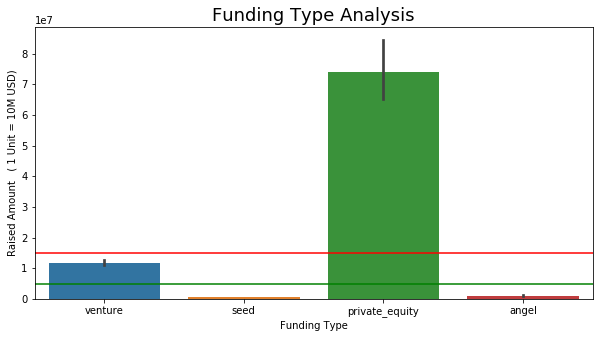

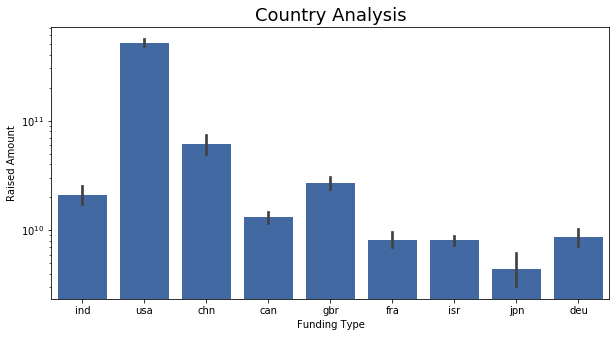

C:\Users\ekupiku\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:281: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



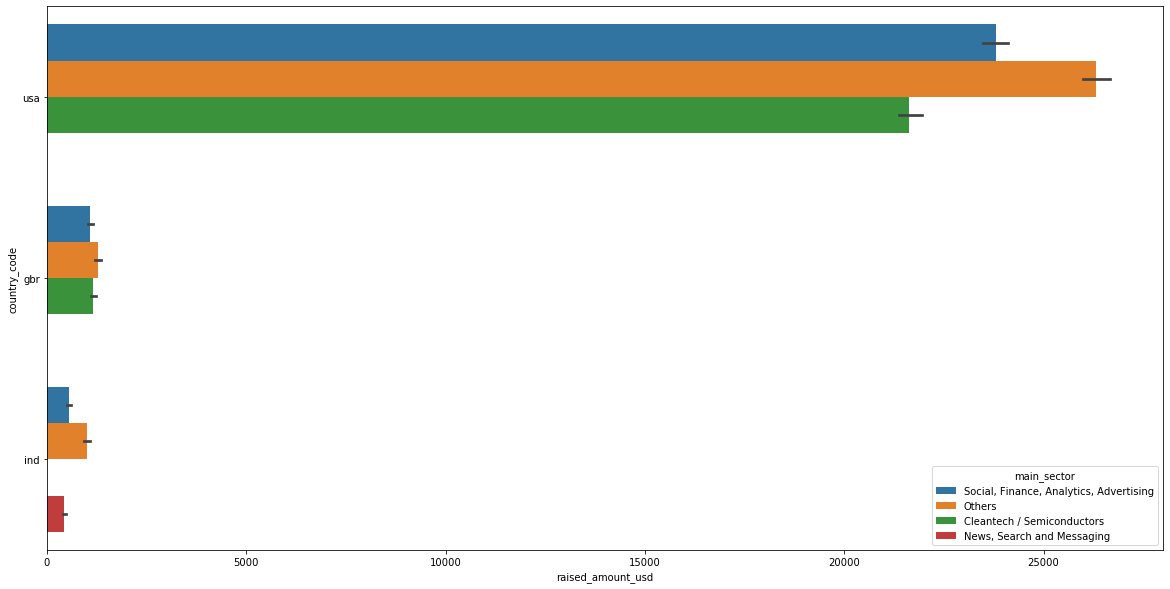

In [2]:
import pandas as pd
import numpy as np
import csv as csv
import seaborn as sbn
import matplotlib.pyplot as plt
import requests
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_territorial_entities_where_English_is_an_official_language').text
from bs4 import BeautifulSoup
%matplotlib inline

# Method to get the dataframe from the file
def dataframe_values(file_path,col_name,separator):
    data_frame = pd.read_csv(file_path,sep= separator, header=0,encoding='ISO-8859-1',engine='python').drop_duplicates()
    data_frame=data_frame.apply(lambda x: x.str.lower() if x.dtype == "object" else x)
    return data_frame

# Method to check if the rounds has more company than companies file
def is_company_present(data_frame1,data_frame2):
    data_frame2[(~data_frame2.company_permalink.isin(data_frame1.permalink))]
    return "Y" if data_frame2[(~data_frame2.company_permalink.isin(data_frame1.permalink))].shape[0] > 0 else "N"

# Generate master frame
def generate_master_frame(rounds_frame, companies_frame):
    # return pd.merge(rounds_frame,companies_frame,how = 'left', left_on = 'company_permalink',right_on='permalink')
    master_frame = pd.merge(rounds_frame,companies_frame,how = 'left', left_on = 'company_permalink',right_on='permalink')
    master_frame.isnull().sum(axis=0)
    # Dropping unnecessary column
    master_frame= master_frame.drop(['founded_at', 'city','region','status','homepage_url','funding_round_code','funded_at'], axis = 1)
    #Dropping rows based on null columns
    master_frame = master_frame[~(master_frame['raised_amount_usd'].isnull() | master_frame['country_code'].isnull() |
                                master_frame['category_list'].isnull())]
    return master_frame

# calculate mean
def calculate_mean_funding_type(master_frame, funding_type):
    funding_data = master_frame.loc[master_frame.funding_round_type == funding_type,:]
    return funding_data["raised_amount_usd"].mean()
# sum
def calculate_sum_funding_type(master_frame, funding_type):
    funding_data = master_frame.loc[master_frame.funding_round_type == funding_type,:]
    return funding_data["raised_amount_usd"].sum()

# Data cleaning
def data_cleaning(rounds,companies):
   
    # create rounds dataframe  
    rounds_frame=dataframe_values(rounds,"company_permalink",",")
    rounds_frame.company_permalink = rounds_frame.company_permalink.str.encode('ISO-8859-1').str.decode('ascii', 'ignore')

    # create companies dataframe
    companies_frame=dataframe_values(companies,"permalink","\t")
    companies_frame.permalink = companies_frame.permalink.str.encode('ISO-8859-1').str.decode('ascii', 'ignore')
    companies_frame.name = companies_frame.name.str.encode('ISO-8859-1').str.decode('ascii', 'ignore')
    # display the unique companies in rounds file
    print("How many unique companies are present in rounds2? ",len(rounds_frame['company_permalink'].unique()))
    # display the unique companies in companies file
    print("How many unique companies are present in companies file? ",len(companies_frame['permalink'].unique()))
    # to check if there any companies in the rounds2 file which are not  present in companies ? Answer Y/N.
    print("if there any companies in the rounds2 file which are not  present in companies ? ",is_company_present(companies_frame,rounds_frame))

    # Merge companies and rounds so that variables fro, company are added to the rounds2 data frame
    master_frame=generate_master_frame(rounds_frame, companies_frame)
    # Number of observations in masterframe
    print("Observations in masterframe",master_frame.shape[0])
    return master_frame

# Funding type analysis
def funding_type_analysis(master_frame):
    # Retain master_frame with only 4 funding types
    master_frame = master_frame[(master_frame['funding_round_type'] == 'venture')
                            | (master_frame['funding_round_type'] == 'seed')
                            | (master_frame['funding_round_type'] == 'angel')
                            | (master_frame['funding_round_type'] == 'private_equity')]
    master_frame.head()
    #Converting $ to million $ as range of investment is 5-15 million
    master_frame['raised_amount_usd'] = master_frame['raised_amount_usd']/1000000
    master_frame.head()
   
    # Average funding amount of venture type
    print("Average funding amount of venture type: ",calculate_mean_funding_type(master_frame,"venture"))
    # Average funding amount of angel type
    print("Average funding amount of angel type: ",calculate_mean_funding_type(master_frame,"angel"))
    # Average funding amount of seed type
    print("Average funding amount of seed type: ",calculate_mean_funding_type(master_frame,"seed"))
    # Average funding amount of private equity type
    print("Average funding amount of private equity type: ",calculate_mean_funding_type(master_frame,"private_equity"))
 

    # Based on mean data for funding type and investment range is 5 to 15 million USD per investment round, Sparks fund should invest in venture
    # Retaining rows with only venture type.
    master_frame = master_frame[master_frame['funding_round_type'] == 'venture']

    #Dropping the column 'funding_round_type' as it is going to be venture
    master_frame = master_frame.drop(['funding_round_type'], axis = 1)
    return master_frame

# Country Analysis
def country_analysis(master_frame):
    # Top 9 countries with investment
    top9 = master_frame.pivot_table(values = 'raised_amount_usd', index = 'country_code', aggfunc = 'sum')
    top9 = top9.sort_values(by = 'raised_amount_usd', ascending = False)
    top9 = top9.iloc[:9, ]
    print(top9)
   
    top_9_countries=master_frame.groupby(["country_code"]).agg({'raised_amount_usd':sum}).nlargest(9, 'raised_amount_usd')
    top_9_countries.to_csv("top_9_countries.csv")
    # English speaking countries from the wikipedia link
    # Read the data from wikipedia using soup utility
    soup = BeautifulSoup(website_url,'lxml')
    # get first and second tables
    tables = soup.find_all('table',{'class':'wikitable sortable'})[0:2]
    eng_speaking_countries = []
    for table in tables:
        # find all rows in tbody
        table_body=table.find('tbody')
        rows = table_body.find_all('tr')
        for row in rows:
            # find all rows where value for primary language is YES or No (but official and educational)
            if(row.text.find("Yes") or row.text.find("No (but official and educational)")):
                country_codes = row.find_all('td')[2:3]
                for country_code in country_codes:
                    eng_speaking_countries.append(country_code.text.strip().lower())
    print("English speaking countries", eng_speaking_countries)

    #Retaining rows with only USA, GBR and IND country_codes. As SparksFunds wants to invest in only top three English speaking countries.
    master_frame = master_frame[(master_frame['country_code'] == 'usa')
                            | (master_frame['country_code'] == 'gbr')
                            | (master_frame['country_code'] == 'ind')]
    return master_frame
   
# Sector1 Analysis
def sector_analysis1(filename,master_frame):
       
    #Extracting the primary vector value
    master_frame['category_list'] = master_frame['category_list'].apply(lambda x: x.split('|')[0])

    # load mapping dataframe
    mapping_frame=dataframe_values(filename,"category_list",",")
    mapping_frame.category_list = mapping_frame.category_list.replace({'0':'na', '2.na' :'2.0'}, regex=True)
    #Reshaping the mapping dataframe to merge with the master_frame dataframe. Using melt() function to unpivot the table.
    mapping_frame = pd.melt(mapping_frame, id_vars =['category_list'], value_vars =['Manufacturing','Automotive & Sports',
                                                                'Cleantech / Semiconductors','Entertainment',
                                                                'Health','News, Search and Messaging','Others',
                                                                'Social, Finance, Analytics, Advertising'])
    mapping_frame = mapping_frame[~(mapping_frame.value == 0)]
    mapping_frame = mapping_frame.drop('value', axis = 1)
    mapping_frame = mapping_frame.rename(columns = {"variable":"main_sector"})
    mapping_frame.head()

    # merge mapping and master_frame
    master_frame = master_frame.merge(mapping_frame, how = 'left', on ='category_list')

    #Retaining the rows which have main_sector values
    master_frame = master_frame[~(master_frame.main_sector.isnull())]

    return master_frame

    # Sector 2 analysis to obtain 3 dataframes
def sector_analysis2(master_frame,funding_frame):
   
    D1 = master_frame[(master_frame['country_code'] == 'usa') &
             (master_frame['raised_amount_usd'] >= 5) &
             (master_frame['raised_amount_usd'] <= 15)]
    D1_sector = D1[['raised_amount_usd','main_sector']].groupby('main_sector').agg(['sum', 'count']).rename(
    columns={'sum':'invested_amount','count' : 'investment_count'})
    D1 = D1.merge(D1_sector, how='left', on ='main_sector')

    D2 = master_frame[(master_frame['country_code'] == 'gbr') &
             (master_frame['raised_amount_usd'] >= 5) &
             (master_frame['raised_amount_usd'] <= 15)]
    D2_sector = D2[['raised_amount_usd','main_sector']].groupby('main_sector').agg(['sum', 'count']).rename(
        columns={'sum':'Total_amount','count' : 'Total_count'})
    D2 = D2.merge(D2_sector, how='left', on ='main_sector')
   

    D3 = master_frame[(master_frame['country_code'] == 'ind') &
             (master_frame['raised_amount_usd'] >= 5) &
             (master_frame['raised_amount_usd'] <= 15)]
    D3_sector = D3[['raised_amount_usd','main_sector']].groupby('main_sector').agg(['sum', 'count']).rename(
        columns={'sum':'Total_amount','count' : 'Total_count'})
    D3 = D3.merge(D3_sector, how='left', on ='main_sector')
   
    #Total number of investments (count)
    print("Total number of investment count for USA: ",D1.raised_amount_usd.count())
    print("Total number of investment count for GBR: ",D2.raised_amount_usd.count())
    print("Total number of investment count for IND: ",D3.raised_amount_usd.count())

    #Total amount of investment (USD)
    print("Total number of investment amount for USA: ",round(D1.raised_amount_usd.sum(), 2))
    print("Total number of investment amount for GBR: ",round(D2.raised_amount_usd.sum(), 2))
    print("Total number of investment amount for IND: ",round(D3.raised_amount_usd.sum(), 2))

    #Top sector, second-top, third-top for D1 (based on count of investments)
    #Number of investments in the top, second-top, third-top sector in D1
    print("Top sector for USA: ",D1_sector)

    #Top sector, second-top, third-top for D2 (based on count of investments)
    #Number of investments in the top, second-top, third-top sector in D2
    print("Top sector for GBR: ",D2_sector)

    #Top sector, second-top, third-top for D3 (based on count of investments)
    #Number of investments in the top, second-top, third-top sector in D2
    print("Top sector for IND: ",D3_sector)

    #For the top sector USA , which company received the highest investment?
    company = D1[D1['main_sector']=='Others']
    company = company.pivot_table(values = 'raised_amount_usd', index = 'company_permalink', aggfunc = 'sum')
    company = company.sort_values(by = 'raised_amount_usd', ascending = False).head()
    print("For the top sector USA , which company received the highest investment?",company.head(1))
   
   
    #For the second top sector USA , which company received the highest investment?
    company = D1[D1['main_sector']=='Social, Finance, Analytics, Advertising']
    company = company.pivot_table(values = 'raised_amount_usd', index = 'company_permalink', aggfunc = 'sum')
    company = company.sort_values(by = 'raised_amount_usd', ascending = False).head()
    print("For the second top sector USA , which company received the highest investment?",company.head(1))
   

    #For the top sector GBR , which company received the highest investment?
    company = D2[D2['main_sector']=='Others']
    company = company.pivot_table(values = 'raised_amount_usd', index = 'company_permalink', aggfunc = 'sum')
    company = company.sort_values(by = 'raised_amount_usd', ascending = False).head()
    print("For the second top sector GBR , which company received the highest investment?",company.head(1))
   
    #For the second top sector GBR , which company received the highest investment?
    company = D2[D2['main_sector']=='Social, Finance, Analytics, Advertising']
    company = company.pivot_table(values = 'raised_amount_usd', index = 'company_permalink', aggfunc = 'sum')
    company = company.sort_values(by = 'raised_amount_usd', ascending = False).head()
    print("For the second top sector GBR , which company received the highest investment?",company.head(1))
   
    #For the top sector IND , which company received the highest investment?
    company = D3[D3['main_sector']=='Others']
    company = company.pivot_table(values = 'raised_amount_usd', index = 'company_permalink', aggfunc = 'sum')
    company = company.sort_values(by = 'raised_amount_usd', ascending = False).head()
    print("For the second top sector IND , which company received the highest investment?",company.head(1))
   
    #For the second top sector IND , which company received the highest investment?
    company = D3[D3['main_sector']=='Social, Finance, Analytics, Advertising']
    company = company.pivot_table(values = 'raised_amount_usd', index = 'company_permalink', aggfunc = 'sum')
    company = company.sort_values(by = 'raised_amount_usd', ascending = False).head()
    print("For the second top sector IND , which company received the highest investment?",company.head(1))
   
   
    # Checkpoint 6
   
    # plot showing the fraction of total investments (globally) in angel, venture, seed, and private equity, and the average amount of investment in
    # each funding type. This chart should make it clear that a certain funding type (FT) is best suited for Spark Funds.
    funding_frame = funding_frame[(funding_frame['funding_round_type'] == 'venture')
                            | (funding_frame['funding_round_type'] == 'seed')
                            | (funding_frame['funding_round_type'] == 'angel')
                            | (funding_frame['funding_round_type'] == 'private_equity')]
   
    plt.figure(figsize=(10,5))
    g=sbn.barplot(x='funding_round_type', y='raised_amount_usd', data=funding_frame)
    g.set(xlabel='Funding Type', ylabel='Raised Amount   ( 1 Unit = 10M USD)')
    g.set_title('Funding Type Analysis',fontsize =18)
    plt.axhline(5000000, color='green')
    plt.axhline(15000000, color='red')
    plt.show()
   

   
    # top 9 countries and their investments
    # bar plot with default statistic=mean
    top9 = funding_frame[funding_frame['country_code'].isin(['usa', 'chn', 'gbr', 'ind', 'can', 'fra', 'isr', 'deu', 'jpn' ])]
    top9.groupby('country_code')['raised_amount_usd'].sum().sort_values(ascending=False)
    plt.figure(figsize=(10,5))
    c=sbn.barplot(x='country_code', y='raised_amount_usd', data=top9, estimator=np.sum,color=(0.2, 0.4, 0.7, 0.6))
    c.set_yscale('log')
    c.set(xlabel='Funding Type', ylabel='Raised Amount')
    c.set_title('Country Analysis',fontsize =18)
    plt.show()

    # plot showing the number of investments in the top 3 sectors of the top 3 countries
    sectors=['Automotive & Sports', 'Cleantech / Semiconductors','Entertainment','Health','Manufacturing','News, Search and Messaging','Others','Social, Finance, Analytics, Advertising']
    d1 = D1[D1['main_sector'].isin(["Others","Social, Finance, Analytics, Advertising", "Cleantech / Semiconductors"])]
    d2 = D2[D2['main_sector'].isin(["Others","Social, Finance, Analytics, Advertising","Cleantech / Semiconductors"])]
    d3 = D3[D3['main_sector'].isin(["Others","Social, Finance, Analytics, Advertising","News, Search and Messaging"])]

    frames = [d1, d2, d3]
    result = pd.concat(frames)
    plt.figure(figsize=(20, 10))
    sbn.barplot(y='country_code', x='raised_amount_usd', hue="main_sector", data=result, estimator=np.sum)
    plt.show()

# Main method which will execute the required business steps
def main():
    # define the filenames provided in assignment
    companies="companies.txt"
    rounds="rounds2.csv"
    mapping = "mapping.csv"
    # Data cleaning
    master_frame=data_cleaning(rounds,companies)
    funding_frame=master_frame
    # Funding Type Analysis
    master_frame=funding_type_analysis(master_frame)
   
    # country analysis
    master_frame=country_analysis(master_frame)
   
    # sector analysis 1
    master_frame=sector_analysis1(mapping,master_frame)
    master_frame.to_csv('master_frame.csv')

    # sector analysis 2
    master_frame=sector_analysis2(master_frame,funding_frame)
   
   


if __name__ == '__main__':
    main()